In [162]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

## 0. Знакомство с данными

In [163]:
data = pd.read_csv('Вспомогательные данные\data.csv', sep=';', index_col=['REPORTDATE'], parse_dates=['REPORTDATE'], dayfirst=True)
data

,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


In [164]:
# для удобства работы переведём название признака в нижний регистр
data.columns = data.columns.str.lower()

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


Данные об объемах расчётных счетов физических лиц представлены за каждый день в периоде с 2013-12-30 по 2019-10-10. 

Для дальнейших вычислений возьмём средние значения за недельные интервалы.

In [166]:
data = data.resample('W').mean()
data.head()

,value
REPORTDATE,
2014-01-05,3.422883e+09
2014-01-12,3.510315e+09
2014-01-19,3.503572e+09
2014-01-26,3.411524e+09
2014-02-02,3.797833e+09


## 1. Анализ и преобразование данных

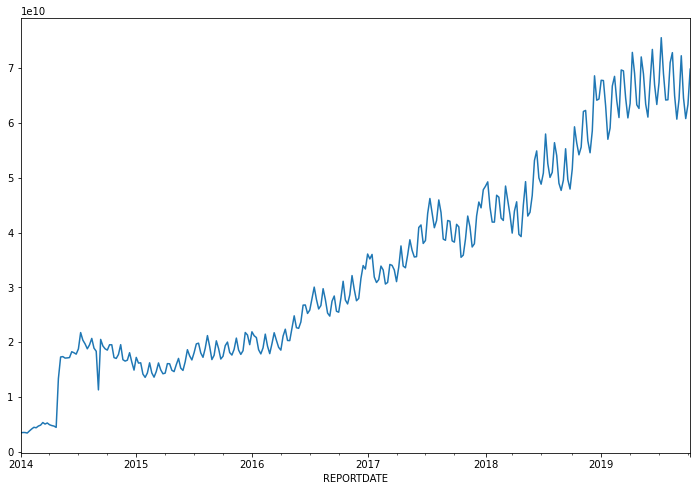

In [167]:
data['value'].plot(figsize=(12,8))
plt.show()

График имеет ярко выраженный тренд. Из это можно сделать вывод о том, что ряд не является стационарным. Для проверки стационарности проведём обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [168]:
def ad_test(data):
    test = adfuller(data, autolag='AIC')
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('num of lags: ', test[2])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')
        
ad_test(data['value'])

adf:  -0.3409237030301542
p-value:  0.9195050044614215
num of lags:  16
Critical values:  {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}
есть единичные корни, ряд не стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Определим порядок интегрированного ряда (зададим смещение периода равным 1):

In [169]:
data_1_diff = data['value'].diff(periods=1).dropna().reset_index()
data_1_diff.index = data_1_diff['REPORTDATE']
data_1_diff = data_1_diff.drop('REPORTDATE', axis=1)

ad_test(data_1_diff['value'])

adf:  -5.696610726633053
p-value:  7.847620268522126e-07
num of lags:  15
Critical values:  {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}
единичных корней нет, ряд стационарен


Для построения модели прогнозирования временного ряда ARIMA необходимо знать следующие параметры:

p — порядок компоненты AR

d — порядок интегрированного ряда (равен 1)

q — порядок компонетны MA

In [170]:
# найдём p и q при помощи AUTO ARIMA:
stepwise_fit = auto_arima(data_1_diff['value'], d=1, suppress_warnings=True, maxiter=200)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  301
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -6815.653
Date:                Mon, 28 Nov 2022   AIC                          13653.305
Time:                        19:49:42   BIC                          13694.047
Sample:                    01-12-2014   HQIC                         13669.610
                         - 10-13-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.377e+07   1.61e-10  -8.53e+16      0.000   -1.38e+07   -1.38e+07
ar.L1         -1.5956      0.058    -27.411      0.000      -1.710      -1.482
ar.L2         -1.4472      0.046    -31.780      0.000      -1.536      -1.358
ar.L3         -1.6171      0.044    -36.608      0.000      -1.704      -1.531
ar.L4         -0.9147      0.057    -16.047      0.000      -1.026      -0.803
ma.L1          0.5159      0.075      6.861      0.000       0.369       0.663
ma.L2         -0.2331      0.060     -3.892      0.000      -0.350      -0.116
ma.L3          0.0953      0.066      1.446      0.148      -0.034       0.225
ma.L4         -0.6321      0.047    -13.442      0.000      -0.724      -0.540
ma.L5         -0.6631      0.083     -7.960      0.000      -0.826      -0.500
sigma2      3.569e+18    1.4e-20   2.54e+38      0.000    3.57e+18    3.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               249.98
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+54. Standard errors may be unstable.
"""

In [173]:
# разделим данные на тренировочные и тестовые в соотношении 90% и 10% соответственно
training_data = data_1_diff.iloc[:-30]
testing_data = data_1_diff.iloc[-30:]
print(training_data.shape)
print(testing_data.shape)

(271, 1)
(30, 1)


## 2. Создание модели прогнозирования, анализ результатов

c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Use

<AxesSubplot:xlabel='REPORTDATE'>

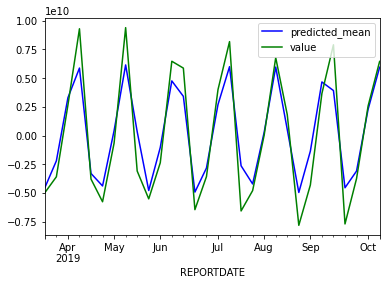

In [174]:
# в ходе экспериментов удалось получить лучший результат со значениями p=7 и q=7
model = ARIMA(training_data['value'], order=(7,1,7)) 
model=model.fit()
model.summary()

start = training_data.shape[0]
end = training_data.shape[0] + testing_data.shape[0]-1
pred = model.predict(start=start, end=end)
pred.index = data_1_diff.index[start:end+1]

pred.plot(legend=True, color='blue')
testing_data['value'].plot(legend=True, color='green')

In [175]:
# оценим метрики модели
mae = metrics.mean_absolute_error(pred, testing_data['value'])
mape = metrics.mean_absolute_percentage_error(pred, testing_data['value'])
r2 = metrics.r2_score(pred, testing_data['value'])

print(f'MAE: {round(mae)} руб.')
print(f'MAPE: {round(mape, 2)} %')
print(f'R2_score: {round(r2, 2)}')


MAE: 1660797222 руб.
MAPE: 0.98 %
R2_score: 0.74


## 3. Прогнозирование

In [230]:
# спрогнозируем объем расчетных счетов физических лиц на год вперёд
pred = model.predict(start=data_1_diff.index[0], end=data_1_diff.index[-1]+relativedelta(months=12)).rename('ARIMA Predictions')
pred_restored = pd.Series(data['value'][0], index=[data['value'].index[0]]).append(pred).cumsum()
pred_restored_df = pd.DataFrame(pred_restored, columns={'ARIMA Predictions':0})
pred_restored_df

C:\Users\alpis\AppData\Local\Temp\ipykernel_13432\2443816332.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_restored = pd.Series(data['value'][0], index=[data['value'].index[0]]).append(pred).cumsum()


,ARIMA Predictions
2014-01-05,3.422883e+09
2014-01-12,3.422883e+09
2014-01-19,3.509441e+09
2014-01-26,3.438549e+09
2014-02-02,3.401487e+09
...,...
2020-09-20,7.847079e+10
2020-09-27,7.468778e+10
2020-10-04,7.581441e+10
2020-10-11,8.188140e+10
